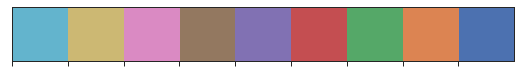

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import seaborn as sns
import sys
import scipy.stats as sc
import pandas as pd

sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('deep', 10, desat = 1)
colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)

sns.palplot(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)

In [118]:
a = 2
b = 5
c = 1
d = 1

def x_dot(x, y, omega):
    dxdt = a*omega - (b + d) * x + c/(omega**2) * x**2 * y
    return dxdt

def y_dot(x, y, omega):
    dydt = b*x - c/(omega**2) * x**2 * y
    return dydt
    

def x_mark(omega, a, d):
    return a*omega / d

def y_mark(omega, a, b,  c, d):
    return omega * b * d / (c * a)


# d**2 /(a*c) * (omega + 1/(d**2) + 1)

In [119]:
# Euler method

def euler(var_change, omega, dt, t_max):
    var = var_change*omega
    x = var[0]
    y = var[1]
    t = 0
    x_list = []
    y_list = []
    t_list = []
    while t < t_max:
        x_list.append(x)
        y_list.append(y)
        t_list.append(t)
        x += dt * x_dot(x, y, omega)
        y += dt * y_dot(x, y, omega)
        t += dt
    return x_list, y_list, t_list


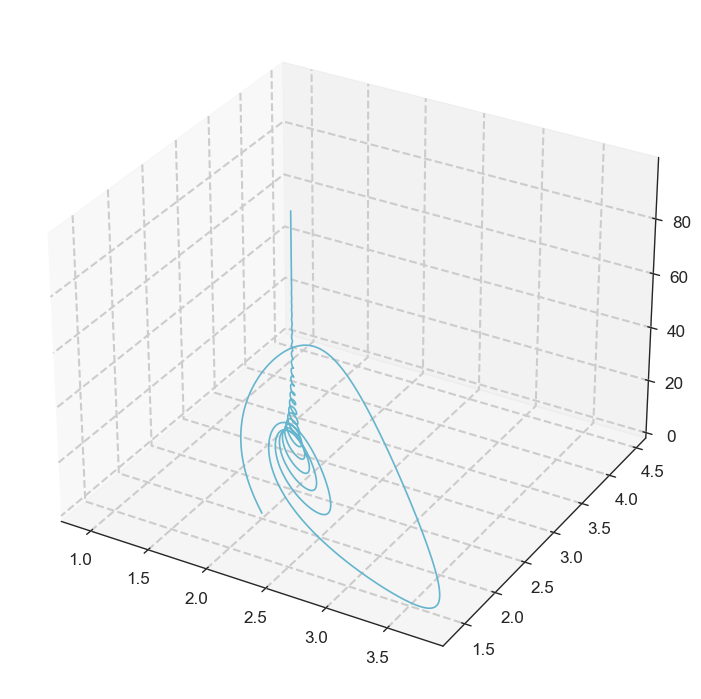

In [120]:

omega = 1
var_change = np.array([2, 2])
dt = 0.01
t_max = 100

x_list, y_list, t_list = euler(var_change, omega, dt, t_max)
x_star = x_mark(omega, a, d)
y_star = y_mark(omega, a, b, c, d)

# 3D plot
fig = plt.figure(figsize=(16,9), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_list, y_list, t_list)


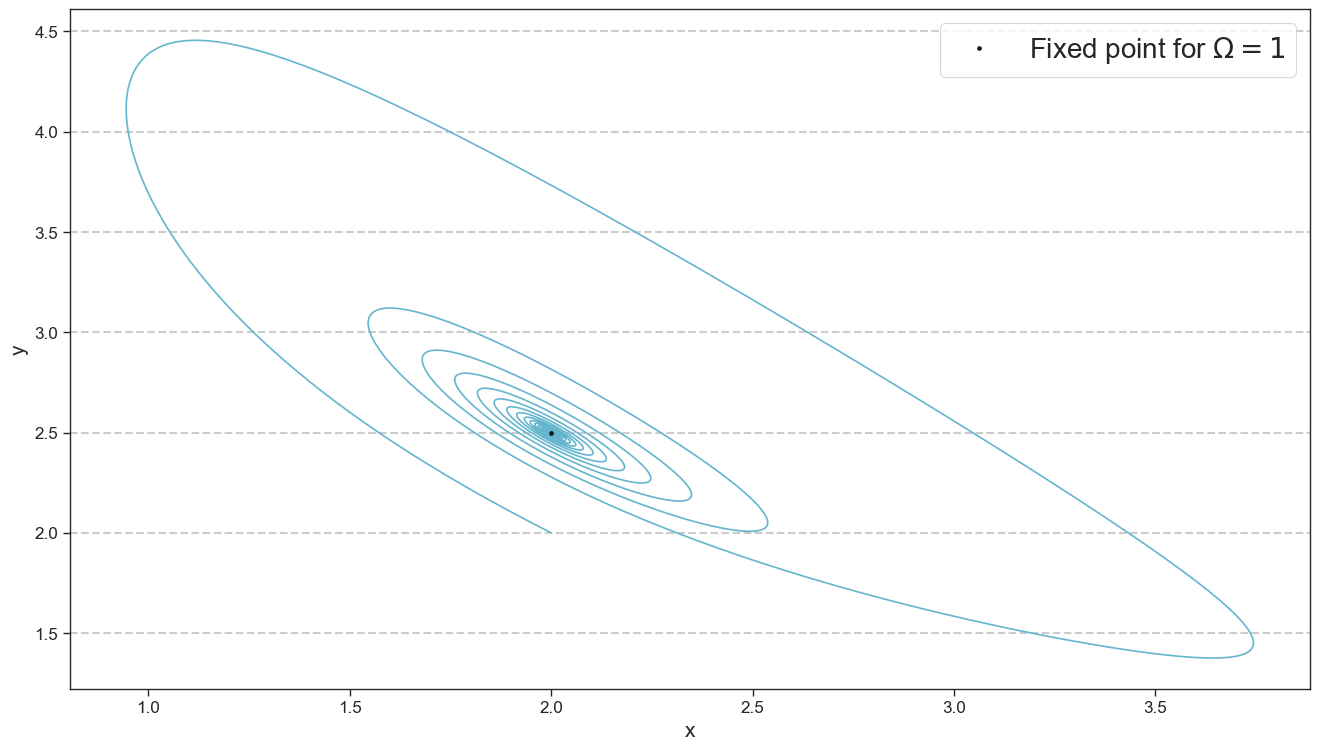

In [121]:
# 2D plot
fig = plt.figure(figsize=(16,9), dpi=100)
plt.plot(x_list, y_list)
plt.plot(x_star, y_star, 'k.', label=f'Fixed point for $\Omega = 1$')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)

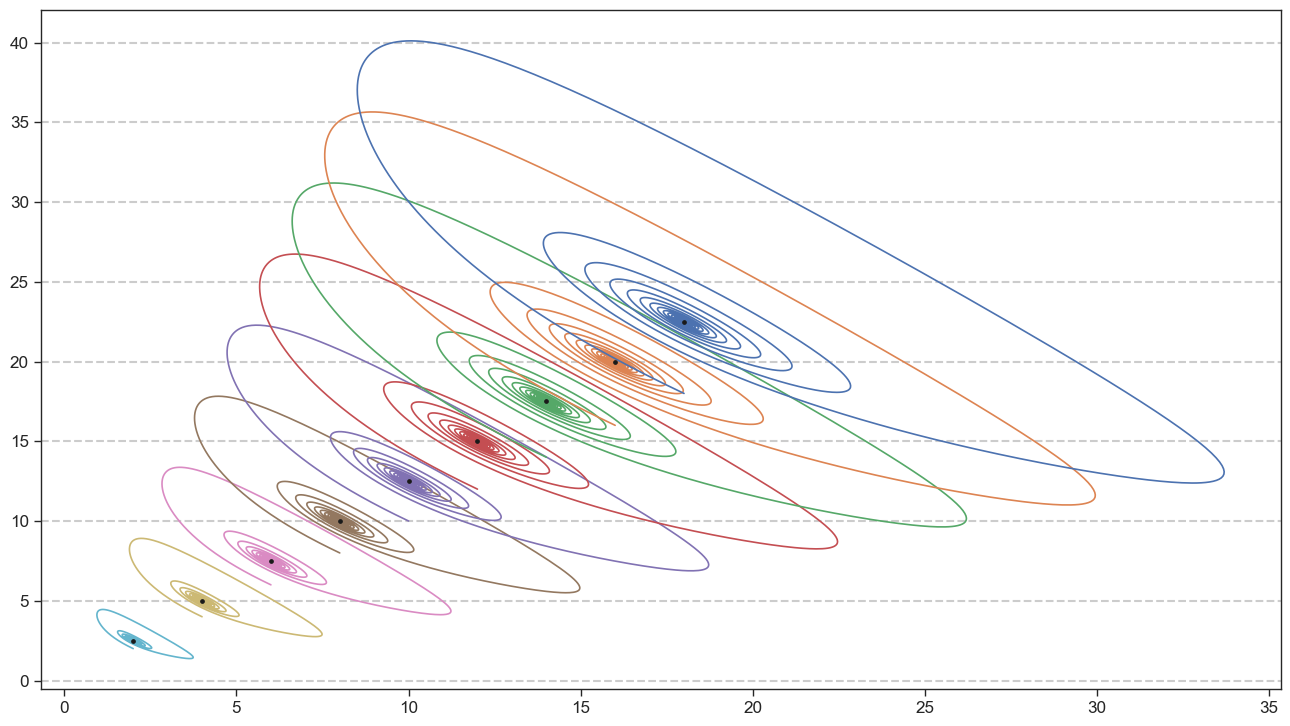

In [122]:
omega = np.arange(1, 10, 1)
var_change = np.array([2, 2])
x_mark_list = []
y_mark_list = []


plt.figure(figsize=(16,9), dpi=100)
for i in omega:
    x_list, y_list, t_list = euler(var_change, i, dt, t_max)
    x_mark_list.append(x_mark(i, a, d))
    y_mark_list.append(y_mark(i, a, b, c, d))
    plt.plot(x_list, y_list, label=f'omega = {i}')

plt.plot(x_mark_list, y_mark_list, 'k.', label='Stable fixed point')